# Sentiment on Twitter
#### #Covid, #CovidVaccine and #PfizerBioNTech

#CovidVaccine from https://www.kaggle.com/kaushiksuresh147/covidvaccine-tweets  
#PfizerBioNTech from https://www.kaggle.com/gpreda/pfizer-vaccine-tweets  
#Covid19 from https://www.kaggle.com/gpreda/covid19-tweets  

To execute the notebook, download the .csv files from the kaggle links and unzip them into `./data`  

This notebook uses the nbextension `sideline`, developed by the author of this notebook. Get it on [GitHub](https://github.com/LuisKolb/sideline) for the best experience.  

Before running this notebook, make sure to unzip the provided data in ./data!  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from string import punctuation 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# hypothesis testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

# Global Parameters
sns.set()
pd.set_option('display.max_colwidth', False)

In [2]:

covid = pd.read_csv('data/covid19_tweets.csv')
covid['hashtag'] = "#Covid19"
covidvaccine = pd.read_csv('data/covidvaccine.csv')
covidvaccine['hashtag'] = "#CovidVaccine"
pfizer = pd.read_csv('data/vaccination_tweets.csv')
pfizer['hashtag'] = "#PfizerBioNTech"

tweets = pd.concat([covid, covidvaccine, pfizer])
#tweets.info()

In [3]:
#from https://medium.com/python-in-plain-english/twitter-sentiment-analysis-using-vader-tweepy-b2a62fba151e
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def process_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [4]:
tweets['text_processed'] = process_tweets(tweets['text'])

In [5]:
analyzer = SentimentIntensityAnalyzer()

tweets['scores'] = tweets['text_processed'].apply(lambda text: analyzer.polarity_scores(text))

In [6]:
tweets['neg'] = tweets.scores.apply(lambda o: o.get('neg'))
tweets['neu'] = tweets.scores.apply(lambda o: o.get('neu'))
tweets['pos'] = tweets.scores.apply(lambda o: o.get('pos'))
tweets['compound'] = tweets.scores.apply(lambda o: o.get('compound'))
#tweets.head()

In [7]:
tweets = tweets.replace('\n','', regex=True)
#tweets = tweets.replace('&amp',' ', regex=True)
#tweets = tweets.replace('\s+', ' ', regex=True)

In [8]:
#tweets.to_excel('data.xlsx')

In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221081 entries, 0 to 3513
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         221081 non-null  object 
 1   user_location     175127 non-null  object 
 2   user_description  208206 non-null  object 
 3   user_created      221081 non-null  object 
 4   user_followers    221081 non-null  int64  
 5   user_friends      221081 non-null  int64  
 6   user_favourites   221081 non-null  int64  
 7   user_verified     221081 non-null  bool   
 8   date              221081 non-null  object 
 9   text              221081 non-null  object 
 10  hashtags          157206 non-null  object 
 11  source            221002 non-null  object 
 12  is_retweet        221081 non-null  bool   
 13  hashtag           221081 non-null  object 
 14  id                3514 non-null    float64
 15  retweets          3514 non-null    float64
 16  favorites         3514

In [10]:
tweets['date'] = pd.to_datetime(tweets['date'])
df1 = tweets.copy(deep=True)
df1.date = df1.date.dt.normalize()
df1 = df1.set_index('hashtag')

cov_byDate = df1.loc['#Covid19'].groupby('date').mean()
cov_byDate['size'] = df1.loc['#Covid19'].groupby('date').size().to_frame()
vax_byDate = df1.loc['#CovidVaccine'].groupby('date').mean()
vax_byDate['size'] = df1.loc['#CovidVaccine'].groupby('date').size().to_frame()
pfi_byDate = df1.loc['#PfizerBioNTech'].groupby('date').mean()
pfi_byDate['size'] = df1.loc['#PfizerBioNTech'].groupby('date').size().to_frame()

In [11]:
#cov_byDate.to_excel('cov_byDate.xlsx')
#vax_byDate.to_excel('vax_byDate.xlsx')
#pfi_byDate.to_excel('pfi_byDate.xlsx')

In [12]:
#vax_byDate.reset_index()[['date','compound']].head(50)

In [13]:
#positive tweets
pos_tweets = tweets.query("compound > 0.05").groupby('hashtag').size()/tweets.groupby('hashtag').size()
pos_tweets = pos_tweets.to_frame().reset_index()
pos_tweets = pos_tweets.rename(columns={0:'percentage'})
pos_tweets

,hashtag,percentage
0,#Covid19,0.385711
1,#CovidVaccine,0.449492
2,#PfizerBioNTech,0.430279


In [14]:
#negative tweets
neg_tweets = tweets.query("compound < -0.05").groupby('hashtag').size()/tweets.groupby('hashtag').size()
neg_tweets = neg_tweets.to_frame().reset_index()
neg_tweets = neg_tweets.rename(columns={0:'percentage'})
neg_tweets

,hashtag,percentage
0,#Covid19,0.267046
1,#CovidVaccine,0.201019
2,#PfizerBioNTech,0.174161


In [15]:
tweets.query("compound < -0.05").groupby('hashtag').size()

hashtag
#Covid19           47830
#CovidVaccine      7731 
#PfizerBioNTech    612  
dtype: int64

In [16]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/luis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/luis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/luis/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/luis/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [17]:
#import geograpy

#locations = tweets.copy(deep=True)
#locations = locations.dropna(subset=['user_location'])
#locations['country_parsed'] = locations['user_location'].apply(lambda str: geograpy.get_geoPlace_context(text=str).countries)

#locations = locations[locations.country_parsed.str.len() > 0]
#locations['country_parsed'] = locations['country_parsed'].apply(lambda arr: arr[0])

#locations.to_excel('pfi_locations.xlsx')
#locations.to_csv('locations.csv')

In [20]:
# parsing countries from every user_location takes very long,
#   so instead of recomputing on every execution of the nb, save and read csv
#locations = pd.read_excel('pfi_locations.xlsx')
locations = pd.read_csv('locations.csv')
locations

/home/luis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,id,retweets,favorites,text_processed,scores,neg,neu,pos,compound,country_parsed
0,1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,...,NaN,NaN,NaN,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A…,"{'neg': 0.065, 'neu': 0.829, 'pos': 0.106, 'compound': 0.2263}",0.065,0.829,0.106,0.2263,United Kingdom
1,4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,...,NaN,NaN,NaN,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 …,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.3182}",0.000,0.796,0.204,0.3182,India
2,6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a friendly place. Corporate blog of @ITMGroup by @Sharlyn_Lauby. Cheers!,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,...,NaN,NaN,NaN,"How #COVID19 Will Change Work in General (and recruiting, specifically) via/ #Recruiting…","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.0,0.000,0.0000,United States
3,11,Creativegms,"Dhaka,Bangladesh","I'm Motalib Mia, Logo -Logo Designer - Branding - Brand Identity Designer. I like to use my creativity, Client Satisfaction is my focus.motalibmas@gmail.com",2020-01-12 09:03:01,241,1694,8443,False,2020-07-25 12:26:50,...,NaN,NaN,NaN,Order here: #logo #graphicdesigner #logodesign #logodesinger #icon #minimalist #Abstract…,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.0,0.000,0.0000,Bangladesh
4,13,Africa Youth Advisory Board on DRR,Africa,Official account of the Africa Youth Advisory Board on Disaster Risk Reduction (DRR) of @_AfricanUnion . Facilitating meaningful engagement of African Youth.,2019-05-13 06:27:47,830,254,3692,False,2020-07-25 12:26:47,...,NaN,NaN,NaN,Let's all protect ourselves from #COVID19.It's real and the numbers are climbing up fast in the Continent.Let's n…,"{'neg': 0.0, 'neu': 0.88, 'pos': 0.12, 'compound': 0.3818}",0.000,0.88,0.120,0.3818,Costa Rica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284789,2967,Carlos Gutierrez,"Phoenix, AZ","boxer lover, animal advocate, world explorer, physician assistant, PA Education, RT ≠ endorsement #medtwitter",2012-05-01 03:18:08,76,687,488,False,2021-01-03 02:29:14,...,1.3455578027946394e+18,0.0,5.0,"Unfortunately, I got infected at the time of my first appointment, but I finally received my #CovidVaccine today.…","{'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'compound': -0.4215}",0.192,0.808,0.000,-0.4215,South Africa
284790,2969,"Melissa L. Wilk, PharmD","Providence, RI",Clinical Pharmacist @RIHospital. Patient Advocate. Feminist. 🐶 Mom. Wife to EM Dr. @mtwilk -Views are my own-,2012-09-07 04:10:22,63,118,364,False,2021-01-03 01:02:42,...,1.3455360279691223e+18,10.0,170.0,2nd dose of #PfizerBioNTech #CovidVaccine done. No side effects almost 12 hours later. Let the immunity begin!!! Th…,"{'neg': 0.153, 'neu': 0.847, 'pos': 0.0, 'compound': -0.4724}",0.153,0.847,0.000,-0.4724,United States
284791,2971,Becky With The Good Hair,"Seaside, California, USA","Gores sacred oxen, teacher, muck-raker, Santa Cruz 11, #EndTheLockdown Anti-masker! NO mandatory vaccines! Pro-freedom Pro-justice ❤= I read it",2010-01-27 02:03:34,4567,4750,211283,False,2021-01-02 23:38:39,...,1.345514875137663e+18,22.0,31.0,Here's one in Canada.The woman actually died &amp; was revived with CPR.#PfizerBioNTech,"{'neg': 0.217, 'neu': 0.783, 'pos': 0.0, 'compound': -0.5574}",0.217,0.783,0.000,-0.5574,Brazil
284792,2974,Buttercup,Earth,mother of a 🦮 yellow lab. wife of 🕵️‍♂️ PI.

In [21]:
"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
"""

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [22]:
#anova testing guided by https://www.pythonfordatascience.org/anova-python/

sideline - link to subplot 1

relation of country and compound sentiment on pfizer vaccine

sideline - link to subplot 2

hashtag as a predictor of compound sentiment

sideline - link to subplot 3

sentiment trends about #CovidVaccination over time

### Dashboard

In [40]:
import plotly.express as px
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash

app = JupyterDash(external_stylesheets=[dbc.themes.BOOTSTRAP, 'https://codepen.io/chriddyp/pen/bWLwgP.css'])

# Build App
app.layout = dbc.Container([
    #dbc.Row(html.H1('Covid Tweet Sentiment Analysis')),
    dbc.Row([
        dbc.Col([
            dcc.RadioItems(
                id='bars-radio',
                options=[
                    {'label': 'Positive Tweets  ', 'value': 'positive'},
                    {'label': 'Negative Tweets  ', 'value': 'negative'},
                ],
                value='positive',
                inputStyle={'margin-left': '20px', 'margin-right': '5px'}
            ),
            dcc.Graph(id='bars')
        ], width=4, align='end'),
        dbc.Col(dcc.Graph(id='world_map'), width=8, align='end'),
    ]),
    dbc.Row([
        dbc.Col([
            dbc.Row(dcc.Graph(id='scatter'), align='end'),
        ], width=6),
        dbc.Col([
            dbc.Row(dcc.Graph(id='table'), align='end'),
        ], width=6),
    ]),
    html.Div(id='none',children=[],style={'display': 'none'}),
], style={'width': '95%', 'maxWidth': '95%'})

@app.callback(
    Output('bars', 'figure'),
    Input('bars-radio', 'value'),
)
def update_bars(value):
    if (value == 'positive'):
        df = pos_tweets
        color = '#636EFA'
    elif (value == 'negative'):
        df = neg_tweets
        color = '#EF553B'
    bars = px.bar(df, x='hashtag', y='percentage',
                  color_discrete_sequence=[color],
                  labels=dict(hashtag='Hashtag', percentage='% of all tweets that are '+value),
                  title='Percentage Sentiment of all Tweets (click to filter other charts)'
                 )
    bars.update_layout(clickmode='event+select')
    
    return bars

@app.callback(
    Output('scatter', 'figure'),
    [Input('bars', 'selectedData')],
)
def update_scatter(selectedData):
    selected = '#PfizerBioNTech'
    if (selectedData):
        selected = selectedData['points'][0]['x']
    if (selected == '#Covid19'):
        df = cov_byDate.reset_index()
    elif (selected == '#CovidVaccine'):
        df = vax_byDate.reset_index()
    elif (selected == '#PfizerBioNTech'):
        df = pfi_byDate.reset_index()
    scatter = px.scatter(
        df, x='date', y='compound',
        color='size', size='size',
        render_mode='webgl', title=selected+' Sentiment over Time (>0.05 is positive)',
        labels=dict(date='Date', compound='Average Sentiment per Tweet', size='Tweets Count')
    )
    scatter.update_yaxes(range=[0,0.5])
    scatter.add_shape(type="line",
                  xref='paper',
                  x0=0, 
                  y0=0.05, 
                  x1=1, 
                  y1=0.05
                 )
    return scatter

@app.callback(
    Output('world_map', 'figure'),
    [Input('bars', 'selectedData')],
)
def update_world_map(selectedData):
    selected = '#PfizerBioNTech'
    if (selectedData):
        selected = selectedData['points'][0]['x']
    if (selected == '#Covid19'):
        df = locations.query('hashtag == "#Covid19"').head(5000)
    elif (selected == '#CovidVaccine'):
        df = locations.query('hashtag == "#CovidVaccine"')
    elif (selected == '#PfizerBioNTech'):
        df = locations.query('hashtag == "#PfizerBioNTech"')
    world_map = px.choropleth(df, locations=df['country_parsed'],
                        locationmode='country names',
                        color=df['compound'],
                        title=selected+' overall Sentiment per Country'
                       )
    return world_map

@app.callback(
    Output('table', 'figure'),
    [Input('bars', 'selectedData')],
)
def update_table(selectedData):
    df = tweets[['text', 'user_name', 'compound', 'date', 'hashtag']]
    selected = '#PfizerBioNTech'
    if (selectedData):
        selected = selectedData['points'][0]['x']
    if (selected == '#Covid19'):
        df = df.query('hashtag == "#Covid19"').head(1000)
    elif (selected == '#CovidVaccine'):
        df = df.query('hashtag == "#CovidVaccine"')
    elif (selected == '#PfizerBioNTech'):
        df = df.query('hashtag == "#PfizerBioNTech"')
    table = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.text, df.user_name, df.compound, df.date, df.hashtag],
               fill_color='lavender',
               align='left'),
    columnwidth=[400, 200, 200, 300, 250])
    ])
    table.update_layout(title='All Tweets tagged '+selected)

    return table



In [41]:
app.run_server(mode='external') #mode: inline, external

Dash app running on http://127.0.0.1:8050/


In [25]:
# insight 1

#get countries occuring more than 5 times
vc = locations['country_parsed'].value_counts()
vc = vc[vc>5]
significant_countries = vc.index
significant_countries

#compute anova
df = locations[locations['country_parsed'].isin(significant_countries)]
model = ols('compound ~ C(country_parsed)', data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(country_parsed),142.390333,146.0,0.975276,5.922987,5.931281e-102,0.007317,0.006082
Residual,19317.362647,117317.0,0.164660,NaN,NaN,NaN,NaN


In [26]:
alpha = 0.05
aov_table['PR(>F)']['C(country_parsed)'] < alpha

True

In [39]:
#comp = mc.MultiComparison(locations['compound'], locations['country_parsed'])
#post_hoc_res = comp.tukeyhsd()
#res = pd.DataFrame(post_hoc_res.summary())
#res.columns = res.iloc[0]
#res = res[1:]
#res.to_csv('test.csv') #for some reason, dataframe cannot be searched -> save and reload from csv
#res = pd.read_csv('test.csv')
#res = res.drop(res.columns[0], axis=1)
#res.query('reject == True')

F > 1 and PR(>F), a p-value, is much smaller than alpha (0.05). we reject the null hypothesis that country and sentiment are unrelated on tweets about #PfizerBioNTech. Also, there is a significant difference in compound sentiment between the countries in group1 and group2 above that would be worth investigating further.

In [33]:
# insight 2
model = ols('compound ~ C(hashtag)', data=tweets).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(hashtag),184.264409,2.0,92.132205,550.613249,2.919464e-239,0.004956,0.004947
Residual,36992.214736,221078.0,0.167327,NaN,NaN,NaN,NaN


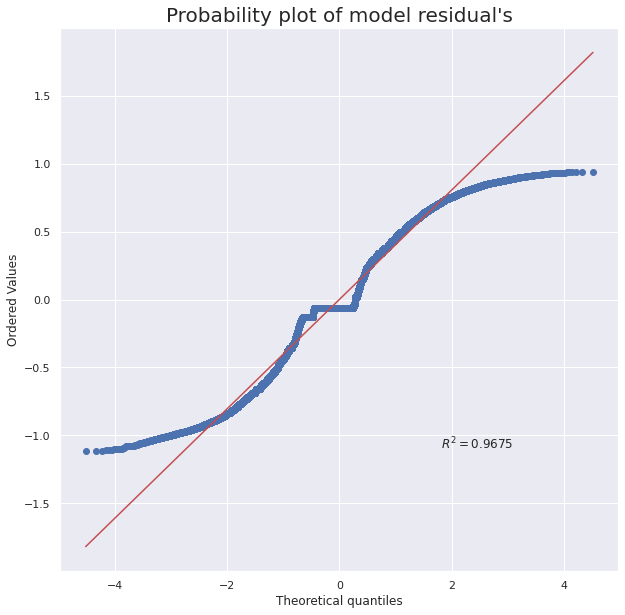

In [34]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [35]:
comp = mc.MultiComparison(tweets['compound'], tweets['hashtag'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

# interesting: the means of covid vs. vaccine hashtag differ strongly from each other,
#    while the #pifzer and #covidvaccine have very similar means 

group1,group2,meandiff,p-adj,lower,upper,reject
#Covid19,#CovidVaccine,0.0722,0.001,0.0668,0.0776,True
#Covid19,#PfizerBioNTech,0.0875,0.001,0.0712,0.1039,True
#CovidVaccine,#PfizerBioNTech,0.0154,0.0836,-0.0015,0.0323,False


Mann_Kendall_Test(trend='increasing', h=True, p=0.052941474280992606, z=1.9353980022674755, Tau=0.14054336468129572, s=538.0, var_s=76985.33333333333, slope=0.0003373529406310832, intercept=0.09882879915197824)


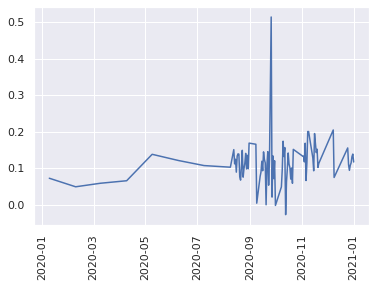

In [37]:
# insight 3
import pymannkendall as mk

df = vax_byDate.reset_index()
df = df.sort_values('date', ascending=True)
plt.plot(df['date'], df['compound'])
plt.xticks(rotation='vertical')

result = mk.original_test(df['compound'], alpha=0.1)
print(result)

Setting alpha to 0.1 instead of 0.05 (90% confidence instead of 95%) shows a statistically significant trend of sentiment in tweets tagged #CovidVaccination becoming more positive (compound sentiment trending upward). The actual p-value is ~0.053, so setting alpha slightly higher here only serves the purpose of illustrating the trend by having the MK-Test function return "increasing", which would otherwise have been classified as "no trend" since it would barely miss the 0.05 cutoff. But since the margin between the "ideal" maximum p-value and the actual calculated p-value is not that large, I adjusted the function parameter to return what I feel is the more accurate result (especially because the data I am working with is rather imperfect). Thus, I conclude that there is a not insignificant upward trend observable here.